# Gaussian Process Regression

'Gaussian Process Regression (GPR) is a *nonparametric*, *Bayesian* approach to regression'. https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 
The Bayesian approach infers a *probability distribution* over all possible values. It works by specifying a **prior**, which is updated based on evidence according to **Bayes Theorem**:
$$ P(\theta|D) \propto P(D|\theta)P(\theta) $$
* $P(\theta|D)$ - posterior
* $P(\theta)$ - prior
* $P(D|\theta)$ - likelihood

The prior & likelihood is usually assumed to be Gaussian.

The key assumption in GP modelling is that our data can be represented as a sample from a *multivariate Gaussian distribution*.

### Basic Introductory Example

https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [1]:
# Generating synthetic data
import numpy as np

X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

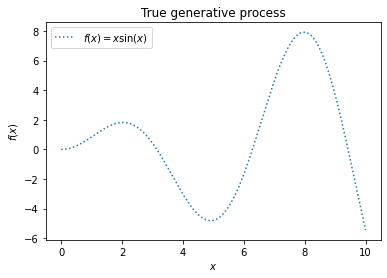

In [2]:
# Plotting data
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

This is the true value which our model is going to be tasked with calculating.

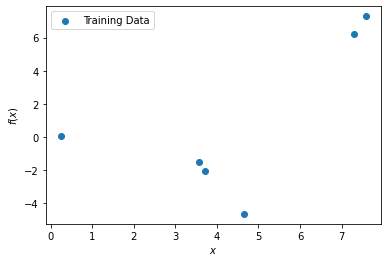

In [3]:
# Noise-free data
rng = np.random.RandomState(11) # keeping seed constant
training_indices = rng.choice(np.arange(y.size), size=6, replace=False) # 6 random indicies from df
X_train, y_train = X[training_indices], y[training_indices] # x & y values of random indicies

plt.scatter(X_train, y_train, label='Training Data')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$");

https://www.apps.stat.vt.edu/leman/VTCourses/GPtutorial.pdf

This is the data we are giving to our Gaussian Processor. For the time being we are not adding any noise.

The **Covariance Function** or **kernel** for a Gaussian is often given by: $k(x,x') = \sigma_f^2 \exp{\left(-\frac{\lvert\lvert{x-x'} \rvert\rvert^2}{2 l^2}\right)}$. 

$$ K = \begin{bmatrix}
         k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_n)\\
         k(x_2, x_1) & k(x_2, x_2) & \dots & k(x_2, x_n)\\
         \vdots & \vdots & \ddots & \vdots\\
         k(x_n, x_1) & k(x_n, x_2) & \dots & k(x_n, x_n)\\
         \end{bmatrix}
         $$

Each observation $y$ can be thought of as related to an underlying function $f(x)$ through a Gaussian noise model: $y = f(x) + \mathcal{N}(0,\sigma_n^2)$. This is very similar to what we did with regression.

To prepare for GPR, we calculate the covariance function. Since the key assumption in GP modelling is that our data can be represented as a sample from a multivariate Gaussian distribution, for a data set $\mathbf{y}$ we have:

$$\begin{bmatrix}
 \mathbf{y}\\
 y*
\end{bmatrix} \sim N\left(0, \begin{bmatrix}
                             K & K_*^T \\
                             K_* & K_{**}
                             \end{bmatrix} \right)$$

where $K_* = \begin{bmatrix}
              k(x_*, x_1) & k(x_*, x_2) & \dots & k(x_*, x_n)
              \end{bmatrix}$
and $K_{**} = k(x_*, x_*) $

Our **posterior** is $p(y_* | \mathbf{y})$. The mean value of $y_*$:
$$ \overline{y}_* = K_* K^{-1} \mathbf{y} $$ 

and the variance is:

$$Var(y_*) = K_{**} - K_*K^{-1}K_*^T$$

The parameters, $\mathbf{\theta} = \{l, \sigma_f, \sigma_n\}$, are what we are trying to optimise for our model to be as accurate as possible. 

In order to optimise this, similar to linear regression, we need to *maximise* the log of the *posterior*. 

$$ \log{p(\mathbf{y}|\mathbf{x},\mathbf{\theta})} = -\frac{1}{2} \mathbf{y}^T K^{-1} \mathbf{y} - \frac{1}{2}\log{|K|} - \frac{n}{2} \log{2 \pi} $$

The reliability of our GP depends upon how well we've chosen our **covariance function**.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

4.98**2 * RBF(length_scale=1.79)

See statistics notes for more information about kernels.

For information about the scipy module see https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

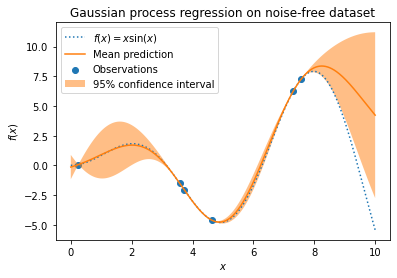

In [5]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)


plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted") # true value
plt.scatter(X_train, y_train, label="Observations") # training data
plt.plot(X, mean_prediction, label="Mean prediction") # gp prediction
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction, # 95% confidence interval
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)                                                
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset");

#### Comment on plot:
The above plot shows how the Gaussian Process regression works. We start off with some randomly selected data from our function, and simply tell our code that the data follows a Gaussian distribution with a Gaussian kernel. The GP then predicts the values of $f(x)$ based on the very limited information given, as well as the uncertainty in the values. We then plot the prediction with a shaded region representing 95% confidence in the values. We see that the confidence levels changes through the graph, with the largest confidence interval occuring at the end in this case.

## Using Noisy Data

In the above example we used data with zero noise, but in all real data there is inevitably a good degree of noise, and thus we should have a Gaussian Process which can handle said noise.

Just as we did with Linear Regression, we add **Gaussian noise** to our data, with an arbitrary standard deviation.

In [6]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

We define our Gaussian process similar to before, but this time we have an extra parameter **alpha** which is equal to the variance of our noisy data.

In [7]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

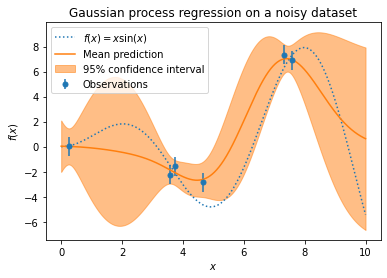

In [8]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

#### Comment on plot:
Here we can see the data points have a slight scatter from the original, and error bars to reflect that. The Gaussian process has correctly accounted for the uncertainty by increasing the size of the 95% confidence interval.